### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting
from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_hparams = os.path.join(path, 'mean_hparams')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_hparams)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_FTD_vs_CN']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass
    
    path_hparams2 = os.path.join(path_hparams, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_hparams2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].transform(impute_mean)

### Search for hyperparams

In [8]:
final_cols = ['diagnosis', 'year_birth', 'sex', 'years_education',
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'moca_vs','ace_vs', 'functionality', 'marital_status',
              'n_children', 'household_members', 'household_income', 'Job_status']

final_cols2 = ['diagnosis', 'ifs_total_score', 'mini_sea_total', 'npi_total',
               'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs', 'functionality' ]

final_cols3 = ['diagnosis', 'year_birth', 'sex', 'years_education','ifs_total_score',
               'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'cognition',
               'functionality', 'marital_status', 'n_children', 'household_members',
               'household_income', 'Job_status' ]


In [9]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and CN
data = train.query("diagnosis != 'AD'")
data['diagnosis'] = data['diagnosis'].replace({'FTD':1, 'CN':0})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'AD'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'FTD':1, 'CN':0})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

# ### Split into FTD and CN
# data_ftd = train.query("diagnosis != 'AD'")
# data_ftd['diagnosis'] = data_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# data_ftd = data_ftd.sample(data_ftd.shape[0], ignore_index=True)
# unseen_ftd = test.query("diagnosis != 'AD'")
# unseen_ftd['diagnosis'] = unseen_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# unseen_ftd = unseen_ftd.sample(unseen_ftd.shape[0], ignore_index=True)

In [10]:
## Random Forest Hparams
rf_grid= {"n_estimators": Integer(low=25, high=1500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=15),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=15)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}


In [11]:
print(path_hparams2)
print(path_res2)

/home/marcelo/GitRepos/Tesis/pred_results/2023-12-06/mean_hparams/RandomForest_FTD_vs_CN
/home/marcelo/GitRepos/Tesis/pred_results/2023-12-06/mean_res/RandomForest_FTD_vs_CN


In [12]:
data1 = data[final_cols].copy()

best, raw = bhs.hparams_search(data1, 'diagnosis', RandomForestClassifier(),
                               rf_grid, rf_param,
                               scaler='MM', test_size= .2,
                               cv=StratifiedKFold(5, shuffle=True), n_iter=100)

raw.to_csv(path_hparams2 + "/RF_hparams.csv")
print('All Done!')
print(best)

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Best score: 0.9539770033191086
	
Test score: 0.9669384057971014
	
Execution time: 4.774094990889231 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 1500}


In [ ]:
##########################################
################## Only test cols
data2 = data[final_cols2].copy()

## Random Forest Hparams

rf_grid2= {"n_estimators": Integer(low=25, high=1500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}


best, raw = bhs.hparams_search(data2, 'diagnosis', RandomForestClassifier(), rf_grid2, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols2.csv")
print('All Done!')
# Save RF hparams
print(best)

In [17]:
###########################################
################## with Cognition col
data3 = data[final_cols3].copy()

## Random Forest Hparams

rf_grid3= {"n_estimators": Integer(low=25, high=1500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=14),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=14)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}

best, raw = bhs.hparams_search(data3, 'diagnosis', RandomForestClassifier(), rf_grid3, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols3.csv")
print('All Done!')
print(best)


Best score: 0.958969495811601
	
Test score: 0.9612771739130435
	
Execution time: 4.655905294418335 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 14, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 1500}


In [13]:
data.shape, unseen_data.shape

((706, 42), (79, 42))

In [19]:
unseen_data.diagnosis.value_counts()

0    54
1    25
Name: diagnosis, dtype: int64

### Load Hyperparams


In [18]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop

#fcols 1
rf_hp1 = pd.read_csv(path_hparams2 + "/RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp1= rf_hp1[rf_hp1['mean_test_score'] < rf_hp1['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

# #fcols 2
# rf_hp2 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols2.csv",
#                     usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
#                              'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
# rf_hp2= rf_hp2[rf_hp2['mean_test_score'] < rf_hp2['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 3
rf_hp3 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols3.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp3= rf_hp3[rf_hp3['mean_test_score'] < rf_hp3['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)



In [20]:
rf_row = 0
rf_hp1.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                           15
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                      1500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.953977
mean_train_score                                                    0.976844
Name: 0, dtype: object

In [16]:
# rf_hp2.iloc[rf_row,:]

In [21]:
rf_hp3.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                           14
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                      1500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.958969
mean_train_score                                                    0.984793
Name: 0, dtype: object

In [22]:
## Models Hparams
# RF
rf_params1= {"n_estimators": rf_hp1.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp1.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp1.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp1.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp1.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp1.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

# rf_params2= {"n_estimators": rf_hp2.loc[rf_row,'param_n_estimators'],
#     "criterion": rf_hp2.loc[rf_row,'param_criterion'],
#     "max_depth": rf_hp2.loc[rf_row,'param_max_depth'],
#     "min_samples_split": rf_hp2.loc[rf_row,'param_min_samples_split'],
#     "min_samples_leaf": rf_hp2.loc[rf_row,'param_min_samples_leaf'],
#     "max_features":rf_hp2.loc[rf_row,'param_max_features'],
#     "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params3= {"n_estimators": rf_hp3.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp3.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp3.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp3.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp3.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp3.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

In [23]:
n_iter = 5000

### Base model: Logistic Regression

In [21]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data1, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:27<00:00, 24.12it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.4557322104771933 minutes
empirical p-value: 0.0



Casting complex values to real discards the imaginary part
invalid value encountered in sqrt
invalid value encountered in sqrt


In [22]:
lr_res.mean()

Accuracy         0.890906
ROC_AUC          0.949328
Precision        0.931924
Recall           0.717061
Sensitivity      0.717061
Specificity      0.974206
F1               0.808450
Efron_pR2        0.611300
mcfadden_pR2    -1.006301
mcfadden_apR2   -1.150708
dtype: float64

In [23]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.008641,0.006079,0.006982,0.012485,0.012485,0.004394,0.010908,0.013512,NaN,NaN


In [24]:
lr_res_r

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,0.555640,0.201319,3.199334+0.000000j,1.246469,3.998769e-02,9.992628e-02
1,ace_vs,-3.569893,0.160632,-7.098041+0.000000j,0.998010,5.215448e-08,7.260911e-07
2,functionality,1.371598,0.198359,7.479376+0.000000j,1.420616,1.986341e-06,6.117994e-05
3,household_income,-0.487346,0.156554,-1.572117+0.000000j,0.655829,2.983801e-01,1.232242e-01
4,household_members,-0.261289,0.167615,-0.489245+0.000000j,0.433279,9.948319e-01,8.818392e-04
5,ifs_total_score,-2.985182,0.170558,-13.862284+0.000000j,1.881659,0.000000e+00,0.000000e+00
6,marital_status,0.643468,0.182353,3.159916+0.000000j,1.100812,2.944716e-02,7.501799e-02
7,mini_sea_total,-0.663474,0.153556,-1.882818+0.000000j,0.576035,1.605741e-01,7.081328e-02
8,mmse_vs,-1.651690,0.204457,-2.567933+0.000000j,0.612524,3.547853e-02,2.651415e-02
9,moca_vs,-3.596632,0.162253,-10.193833+0.000000j,1.433593,0.000000e+00,0.000000e+00


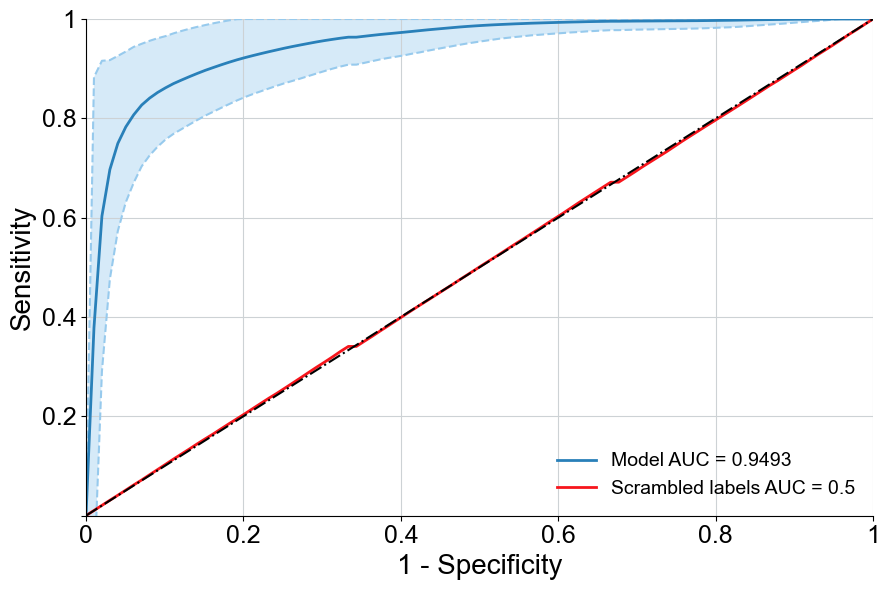

In [25]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [26]:
rf_fimp = bc.permutation_FIMP(data1, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [27]:
# rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

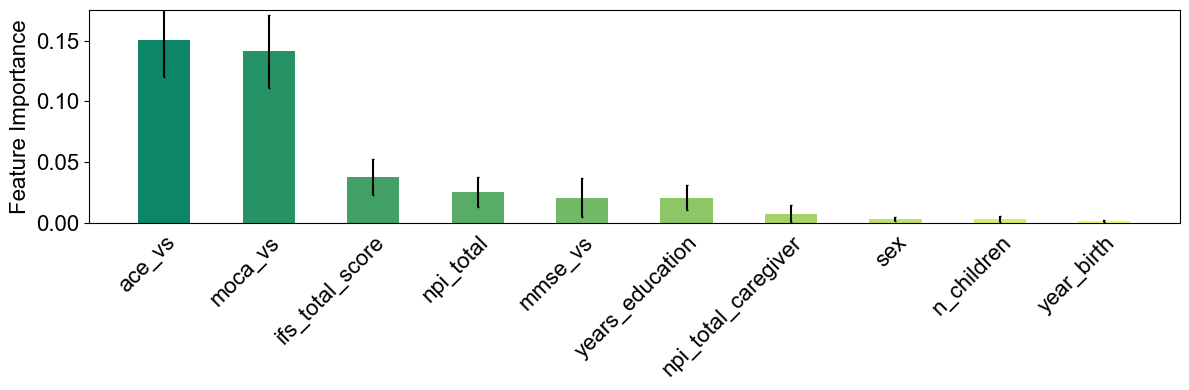

In [28]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

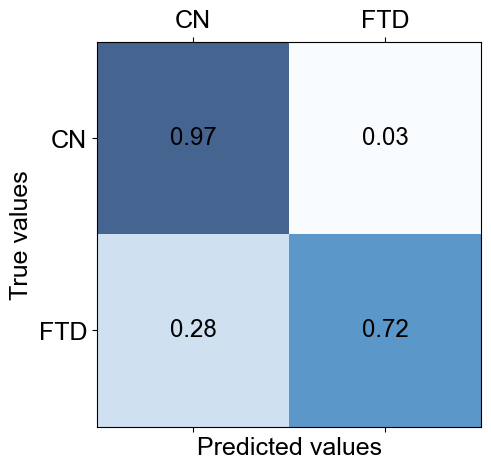

In [29]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['CN', 'FTD'],fname=None)

#### unseen data

In [20]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [21]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [32]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [33]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [34]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8507
Accuracy: 0.8987
Recall: 0.72
F1: 0.8182
Precision:0.9474


In [35]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8507
Bootstrping test ROC score: 	0.9493


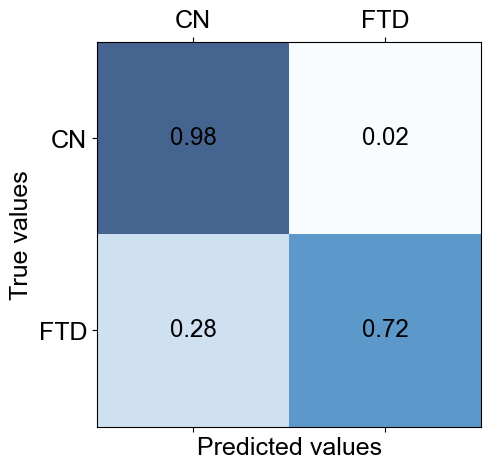

In [36]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'])

### RF Model

#### Bootstrap 1

In [24]:
Model_res1, CI_df1, Model_res_r1, ROC_AUC1, CM1, ROC_chance1, empirical_p_value1 = bc.Bootstrap_tree_classifier(
    data1, 'diagnosis', RandomForestClassifier(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier()


Iterating: 100%|██████████████████| 5000/5000 [19:15<00:00,  4.33it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:19.255808285872142 minutes
empirical p-value: 0.0


In [25]:
path_res2

'/home/marcelo/GitRepos/Tesis/pred_results/2023-12-06/mean_res/RandomForest_FTD_vs_CN'

In [26]:
Model_res1.to_csv(path_res2+ "/Model_res1.csv", index=False)
Model_res1.mean()

Accuracy       0.907958
ROC_AUC        0.950499
Precision      0.889248
Recall         0.820165
Sensitivity    0.820165
Specificity    0.950025
F1             0.851883
Efron_pR2      0.659631
dtype: float64

In [27]:
print("%.4f" % Model_res1['ROC_AUC'].mean())

0.9505


In [28]:
CI_df1.to_csv(path_res2+ "/CI_df1.csv", index=False)
CI_df1

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.008013,0.006012,0.008699,0.010645,0.010645,0.00604,0.009846,0.013134


In [29]:
Model_res_r1.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/Model_res_r1.csv", index=False)
Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,ace_vs,0.215773,0.022878
9,moca_vs,0.190192,0.022422
5,ifs_total_score,0.128852,0.013581
8,mmse_vs,0.121225,0.017767
11,npi_total,0.059041,0.007010
2,functionality,0.056530,0.006820
14,year_birth,0.046874,0.004089
15,years_education,0.038641,0.003555
7,mini_sea_total,0.037718,0.004551
12,npi_total_caregiver,0.035779,0.005249


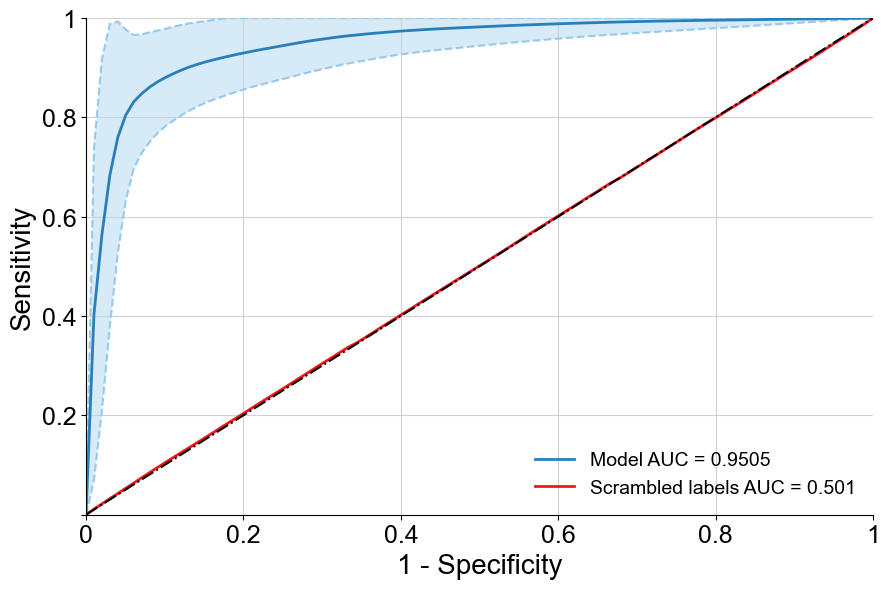

In [30]:
ml_plotting.plot_custom_roc_curve(ROC_AUC1, ROC_chance1, fname=path_res2+ "/ROC_AUC_curve1.png")

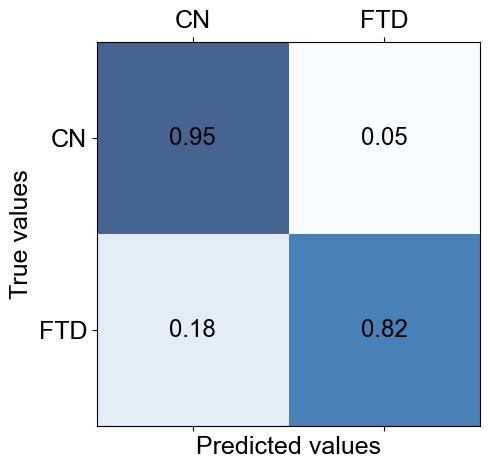

In [31]:
ml_plotting.plot_boostrap_CM(CM1, labels=['CN', 'FTD'],fname=path_res2+ "/CM1.png")

##### Permutation Feature importance

In [32]:
rf_fimp1 = bc.permutation_FIMP(data1, 'diagnosis', RandomForestClassifier(), params=rf_params1, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [33]:
rf_fimp1.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI1.csv")
top_10p1 = rf_fimp1.sort_values('mean', ascending=False).head(10)

In [34]:
top_10p1

,predictor,mean,std
9,ace_vs,0.027757,0.011048
8,moca_vs,0.027195,0.010476
3,ifs_total_score,0.027110,0.008187
1,sex,0.011245,0.004559
5,npi_total,0.010857,0.003270
7,mmse_vs,0.010055,0.008048
6,npi_total_caregiver,0.009363,0.002674
4,mini_sea_total,0.007205,0.003238
10,functionality,0.007075,0.002492
13,household_members,0.004355,0.000759


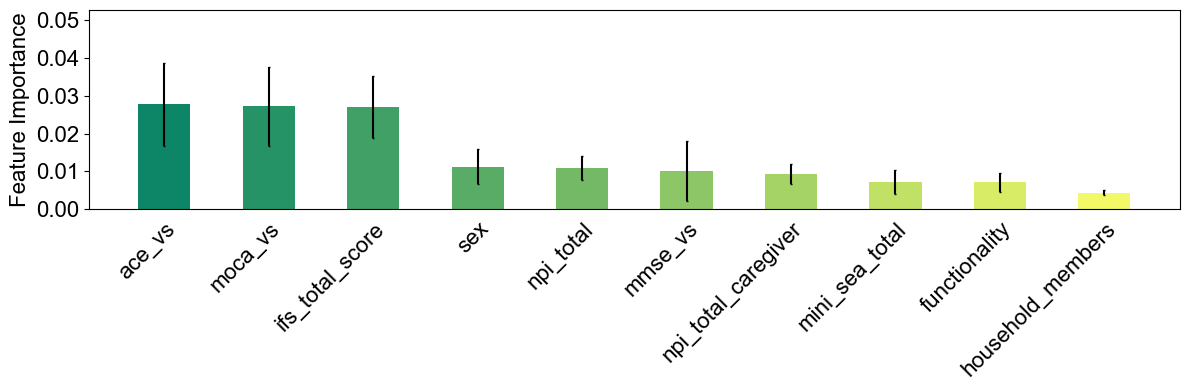

In [35]:
ml_plotting.plot_permutation_FIMP(top_10p1, names='predictor', importances_col='mean', std_col='std')

In [36]:
Model_res_r1.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,ace_vs,0.215773,0.022878
9,moca_vs,0.190192,0.022422
5,ifs_total_score,0.128852,0.013581
8,mmse_vs,0.121225,0.017767
11,npi_total,0.059041,0.007010


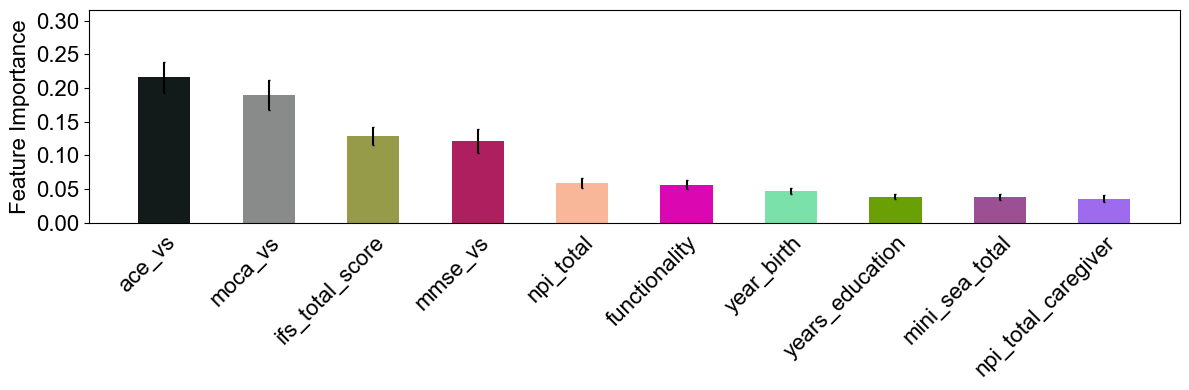

In [37]:
top_10_1 = Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_1, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [38]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [39]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [40]:
# predict & scores
rfc = RandomForestClassifier(**rf_params1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [41]:
unseen_df1 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df1.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df1.to_csv(path_res+ "/unseen1.csv")

In [42]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8181
Accuracy: 0.8101
Recall: 0.84
F1: 0.7368
Precision:0.6562


In [43]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res1['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8181
Bootstrping test ROC score: 	0.9505


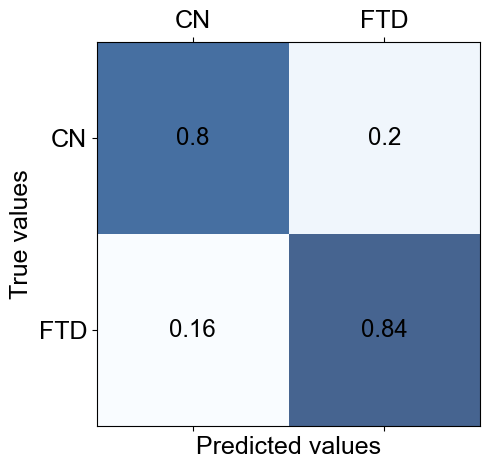

In [44]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'],fname=path_res2+ "/CM_unseen1.png")

#### Shapley

In [45]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

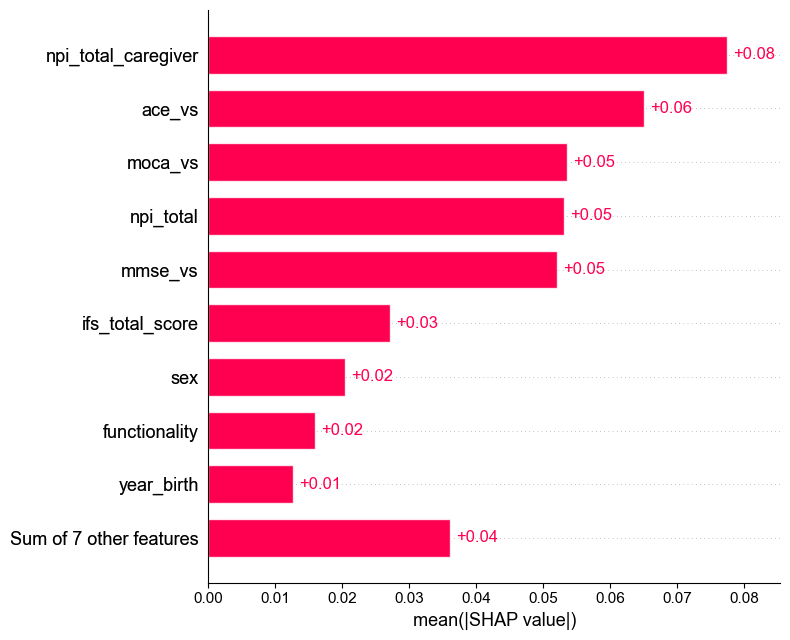

In [46]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 2

In [61]:
Model_res2, CI_df2, Model_res_r2, ROC_AUC2, CM2, ROC_chance2, empirical_p_value2 = bc.Bootstrap_tree_classifier(
    data2, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params2, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=25, n_jobs=-1)


Iterating: 100%|██████████████████| 5000/5000 [05:54<00:00, 14.11it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:5.905570967992147 minutes
empirical p-value: 0.0


In [62]:
Model_res2.to_csv(path_res2+ "/Model_res2.csv", index=False)
Model_res2.mean()

Accuracy       0.883968
ROC_AUC        0.942877
Precision      0.820560
Recall         0.827209
Sensitivity    0.827209
Specificity    0.911165
F1             0.821990
Efron_pR2      0.587587
dtype: float64

In [63]:
print("%.4f" % Model_res2['ROC_AUC'].mean())

0.9429


In [64]:
CI_df2.to_csv(path_res2+ "/CI_df2.csv", index=False)
CI_df2

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.008877,0.006433,0.010636,0.010479,0.010479,0.007886,0.010603,0.013645


In [65]:
Model_res_r2.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r2.csv", index=False)
Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
0,ace_vs,0.217293,0.056322
5,moca_vs,0.212365,0.055062
4,mmse_vs,0.188065,0.051411
2,ifs_total_score,0.150632,0.038717
1,functionality,0.067873,0.017770
6,npi_total,0.066432,0.018494
7,npi_total_caregiver,0.051375,0.016151
3,mini_sea_total,0.045965,0.012955


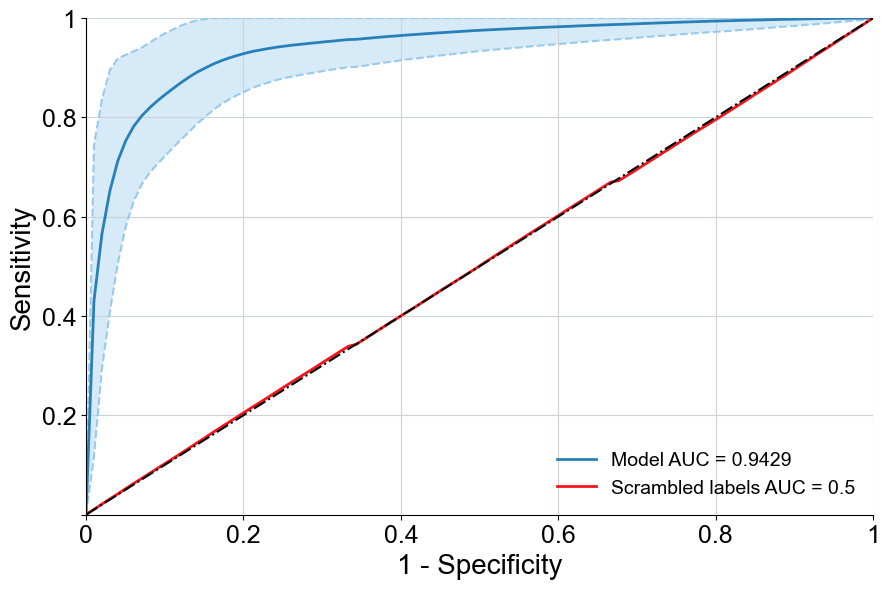

In [66]:
ml_plotting.plot_custom_roc_curve(ROC_AUC2, ROC_chance2, fname=path_res2+ "/ROC_AUC_curve2.png")

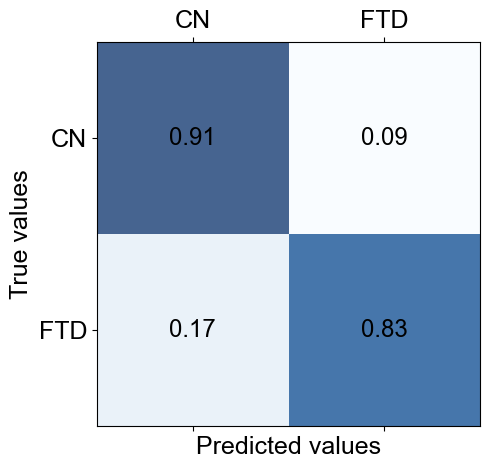

In [67]:
ml_plotting.plot_boostrap_CM(CM2, labels=['CN', 'FTD'],fname=path_res2+ "/CM2.png")

##### Permutation Feature importance

In [68]:
rf_fimp = bc.permutation_FIMP(data2, 'diagnosis', RandomForestClassifier(),
                              params=rf_params2, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [69]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI2.csv")
top_10p2 = rf_fimp.sort_values('mean', ascending=False).head(10)

In [70]:
top_10p2

,predictor,mean,std
0,ifs_total_score,0.029200,0.011264
6,ace_vs,0.027352,0.014817
7,functionality,0.017770,0.006838
5,moca_vs,0.013075,0.012325
2,npi_total,0.009511,0.005941
3,npi_total_caregiver,0.005177,0.005286
4,mmse_vs,-0.000313,0.009531
1,mini_sea_total,-0.000483,0.004418


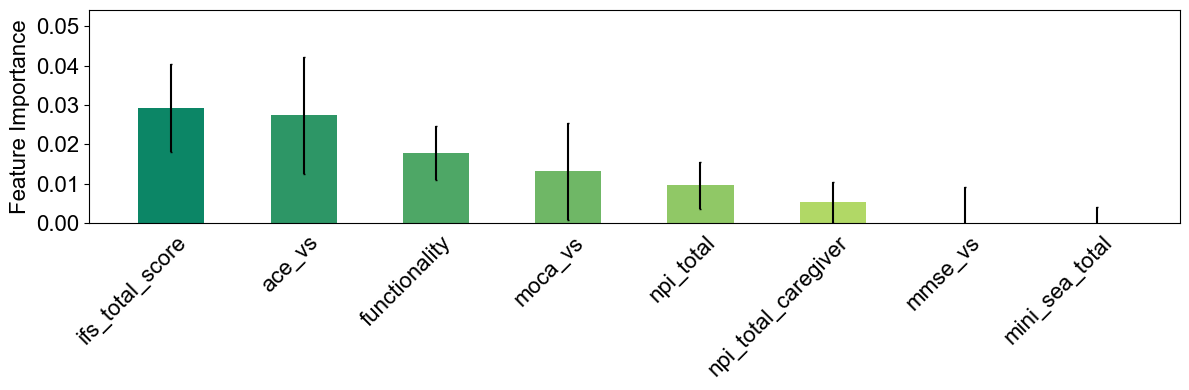

In [71]:
ml_plotting.plot_permutation_FIMP(top_10p2, names='predictor', importances_col='mean', std_col='std')

In [72]:
Model_res_r2.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
0,ace_vs,0.217293,0.056322
5,moca_vs,0.212365,0.055062
4,mmse_vs,0.188065,0.051411
2,ifs_total_score,0.150632,0.038717
1,functionality,0.067873,0.017770


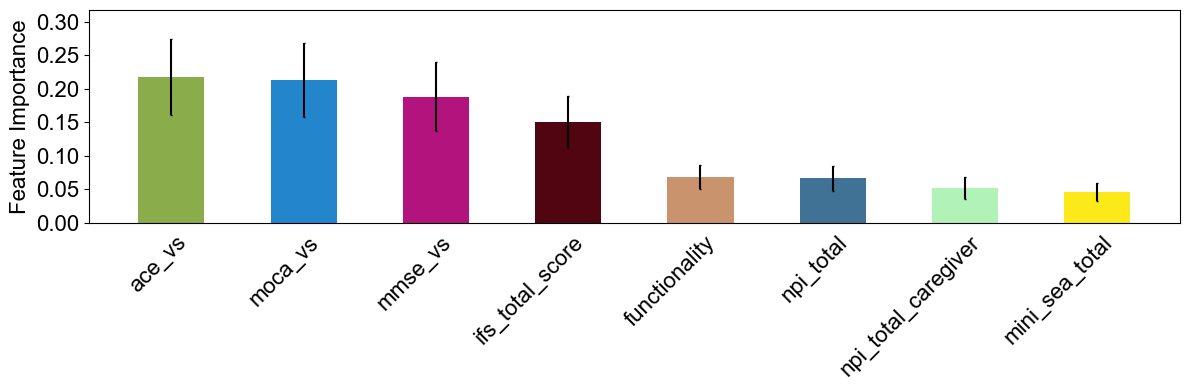

In [73]:
top_10_2 = Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_2, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [74]:
X_train, y_train = data2.drop('diagnosis', axis=1), data2[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data2.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [75]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [76]:
# predict & scores
rfc = RandomForestClassifier(**rf_params2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [77]:
unseen_df2 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df2.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df2.to_csv(path_res2+ "/unseen2.csv")

In [78]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.6481
Accuracy: 0.519
Recall: 1.0
F1: 0.5682
Precision:0.3968


In [79]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res2['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.6481
Bootstrping test ROC score: 	0.9429


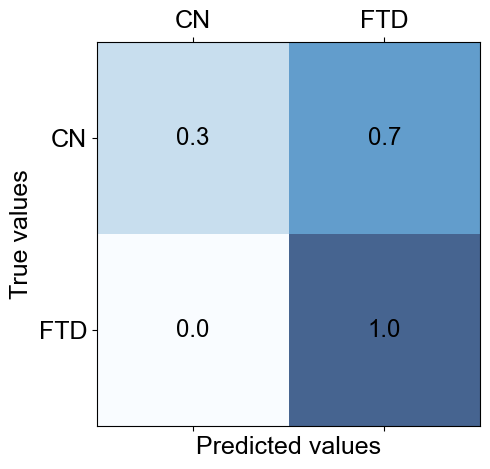

In [80]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'],fname=path_res2+ "/CM_unseen2.png")

In [81]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


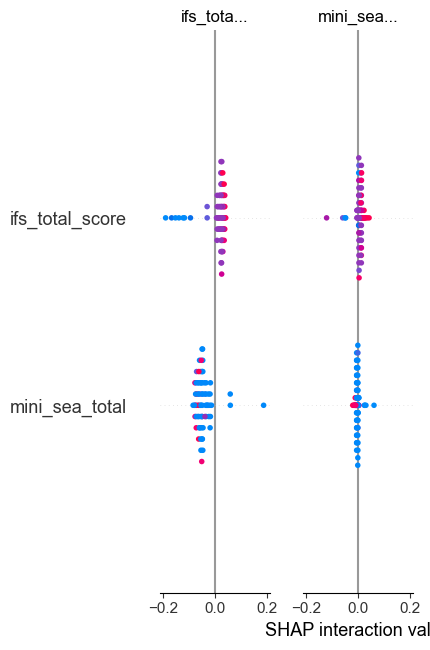

In [82]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

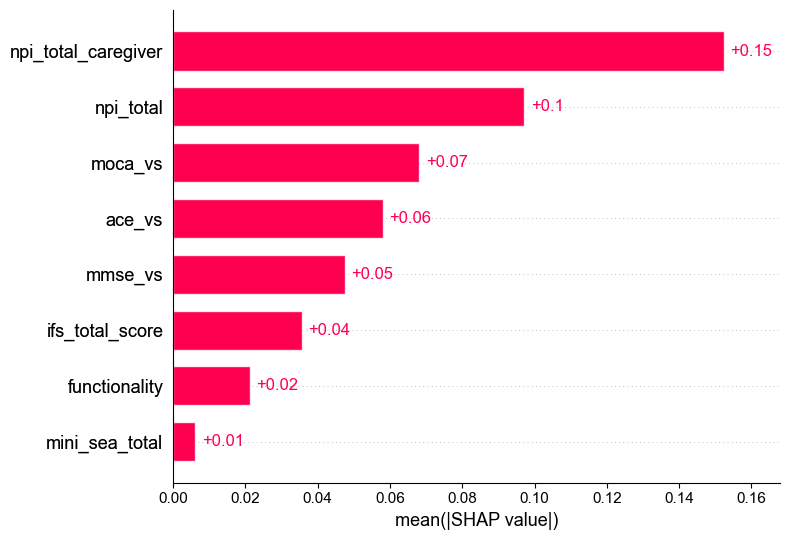

In [83]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 3

In [47]:
Model_res3, CI_df3, Model_res_r3, ROC_AUC3, CM3, ROC_chance3, empirical_p_value3 = bc.Bootstrap_tree_classifier(
    data3, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params3, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=1500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [3:54:33<00:00,  2.81s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:234.56204085350038 minutes
empirical p-value: 0.0


In [48]:
Model_res3.to_csv(path_res2+ "/Model_res3.csv", index=False)
Model_res3.mean()

Accuracy       0.898665
ROC_AUC        0.956451
Precision      0.871144
Recall         0.809387
Sensitivity    0.809387
Specificity    0.941444
F1             0.837622
Efron_pR2      0.492954
dtype: float64

In [49]:
print("%.4f" % Model_res3['ROC_AUC'].mean())

0.9565


In [50]:
CI_df3.to_csv(path_res2+ "/CI_df3.csv", index=False)
CI_df3

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.008365,0.005657,0.009287,0.010887,0.010887,0.006508,0.010223,0.013858


In [51]:
Model_res_r3.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r3.csv", index=False)
Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,cognition,0.317892,0.010161
5,ifs_total_score,0.194733,0.008545
2,functionality,0.089895,0.005798
9,npi_total,0.083345,0.005125
10,npi_total_caregiver,0.064451,0.004476
7,mini_sea_total,0.059528,0.004679
12,year_birth,0.050182,0.003727
13,years_education,0.042974,0.002814
11,sex,0.028306,0.004676
0,Job_status,0.017971,0.002327


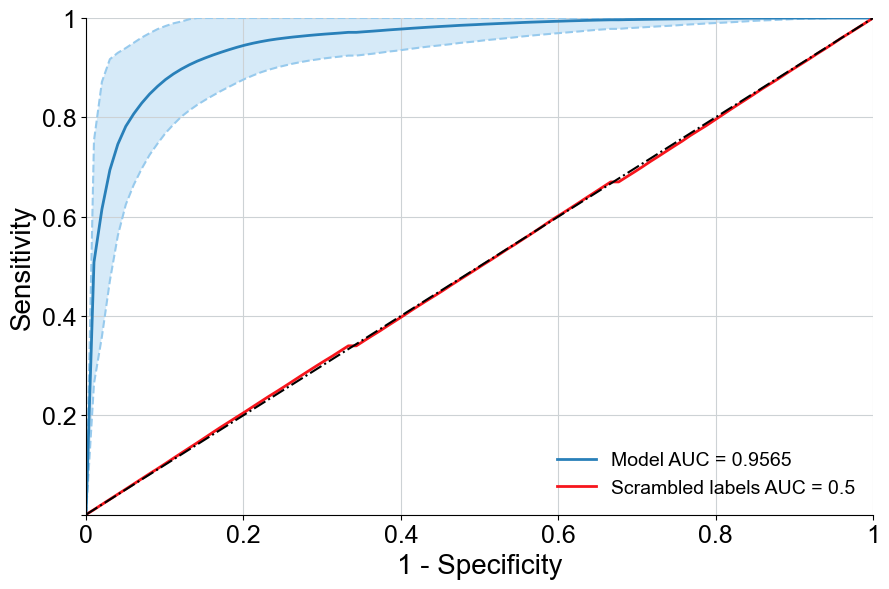

In [52]:
ml_plotting.plot_custom_roc_curve(ROC_AUC3, ROC_chance3, fname=path_res2+ "/ROC_AUC_curve3.png")

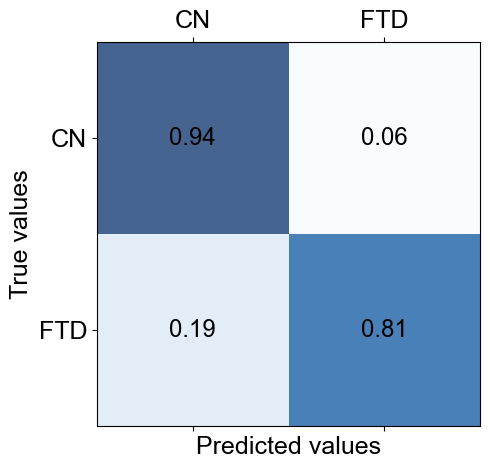

In [53]:
ml_plotting.plot_boostrap_CM(CM3, labels=['CN', 'FTD'],fname=path_res2+ "/CM3.png")

##### Permutation Feature importance

In [54]:
rf_fimp3 = bc.permutation_FIMP(data3, 'diagnosis', RandomForestClassifier(), params=rf_params3, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [55]:
rf_fimp3.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI3.csv")
top_10p3 = rf_fimp3.sort_values('mean', ascending=False).head(10)

In [56]:
top_10p3

,predictor,mean,std
7,cognition,0.154615,0.026133
3,ifs_total_score,0.035473,0.010243
5,npi_total,0.015145,0.004883
4,mini_sea_total,0.012822,0.005488
1,sex,0.011960,0.005618
6,npi_total_caregiver,0.011164,0.004302
8,functionality,0.010583,0.004953
0,year_birth,0.006637,0.003537
11,household_members,0.002108,0.000577
13,Job_status,0.001713,0.001952


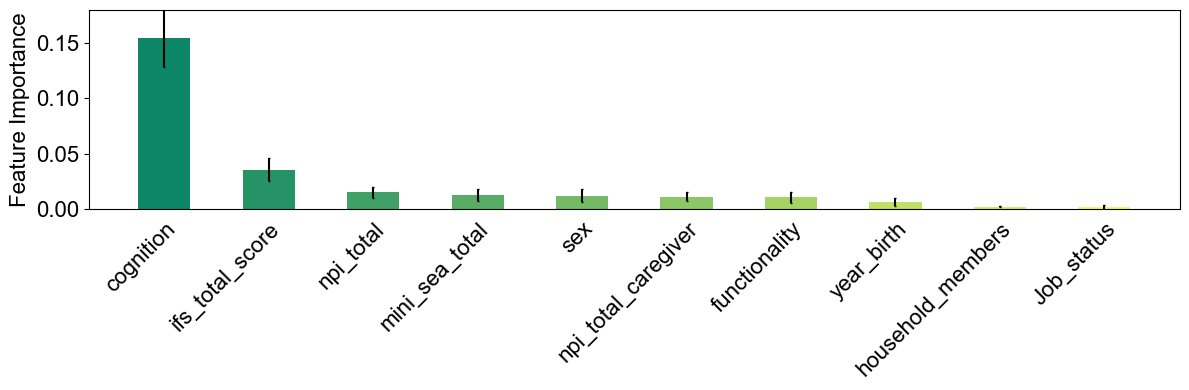

In [57]:
ml_plotting.plot_permutation_FIMP(top_10p3, names='predictor', importances_col='mean', std_col='std')

In [58]:
Model_res_r3.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,cognition,0.317892,0.010161
5,ifs_total_score,0.194733,0.008545
2,functionality,0.089895,0.005798
9,npi_total,0.083345,0.005125
10,npi_total_caregiver,0.064451,0.004476


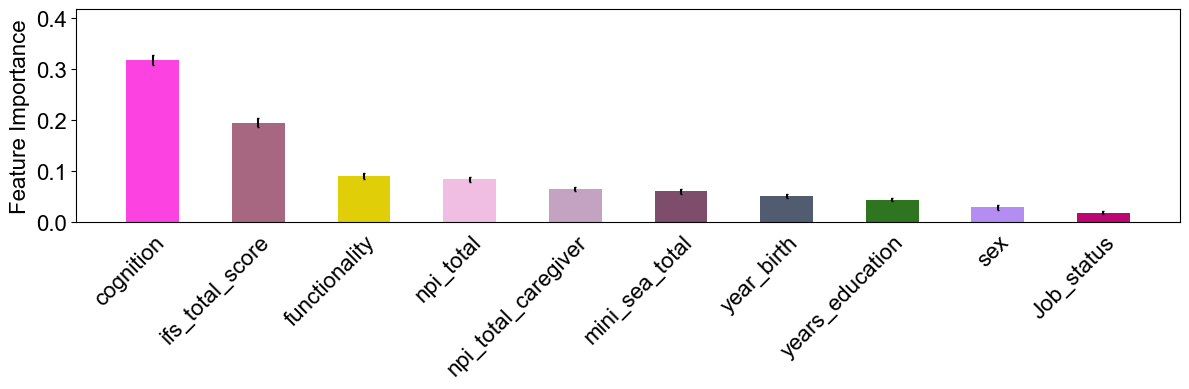

In [59]:
top_10_3 = Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_3, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [60]:
X_train, y_train = data3.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data3.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [61]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [62]:
# predict & scores
rfc = RandomForestClassifier(**rf_params3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [63]:
unseen_df3 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df3.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df3.to_csv(path_res2+ "/unseen3.csv")

In [64]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8041
Accuracy: 0.7468
Recall: 0.96
F1: 0.7059
Precision:0.5581


In [65]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res3['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8041
Bootstrping test ROC score: 	0.9565


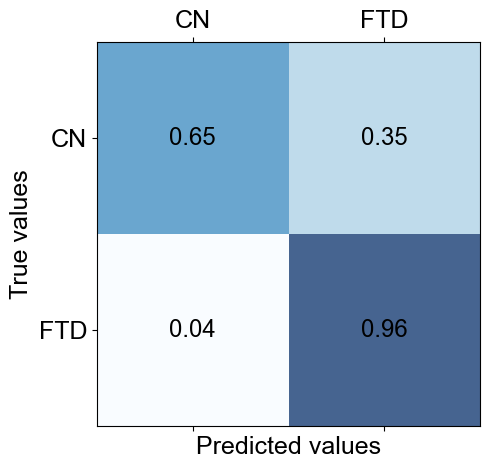

In [66]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'],fname=path_res2+ "/CM_unseen3.png")

In [67]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


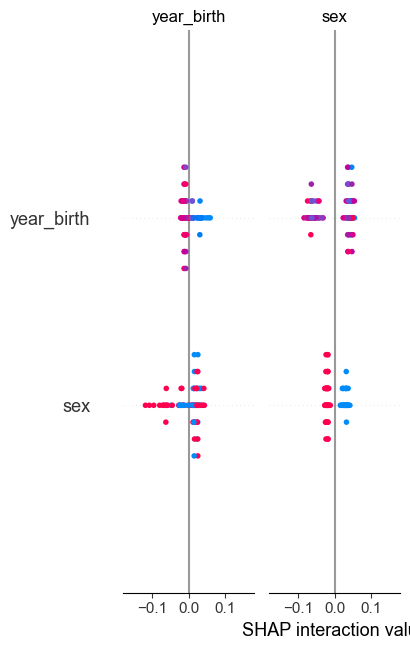

In [68]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

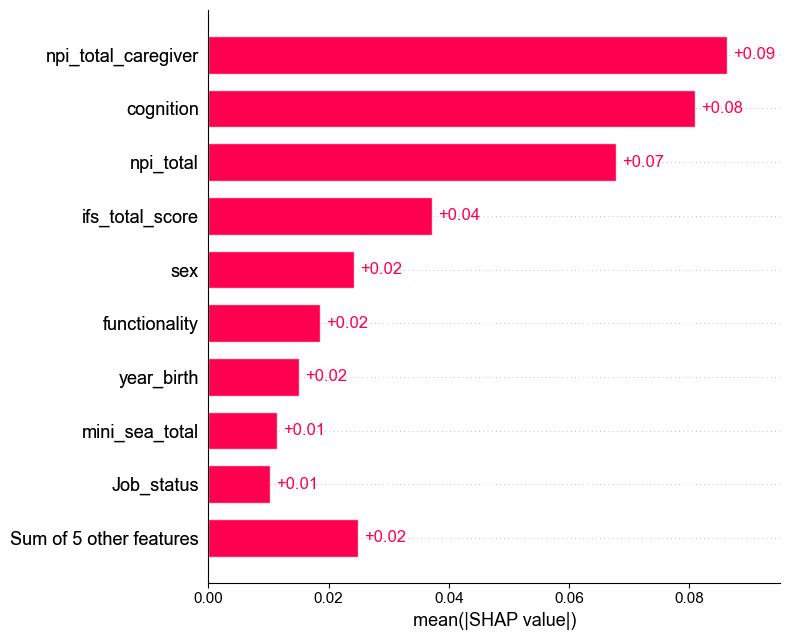

In [69]:
shap.plots.bar(shap_values[:,:,1])

### Sequential feature selector

#### RF

In [107]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [108]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [109]:
rf_params3['max_features'] =1

In [110]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params3), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [111]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.2s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    3.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    3.5s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.2s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    2.8s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.9s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [112]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [113]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[0.8432203389830508, 0.8553191489361702, 0.872...",0.85696,"(cognition,)",0.02688,0.011945,0.008446
2,"(3, 7)","[0.8728813559322034, 0.8808510638297873, 0.885...",0.879613,"(ifs_total_score, cognition)",0.011403,0.005067,0.003583
3,"(3, 5, 7)","[0.902542372881356, 0.8936170212765957, 0.8851...",0.893755,"(ifs_total_score, npi_total, cognition)",0.01602,0.007119,0.005034
4,"(3, 5, 7, 9)","[0.8983050847457628, 0.8893617021276595, 0.914...",0.900853,"(ifs_total_score, npi_total, cognition, marita...",0.023804,0.010578,0.00748
5,"(3, 5, 6, 7, 9)","[0.8983050847457628, 0.8978723404255319, 0.914...",0.90369,"(ifs_total_score, npi_total, npi_total_caregiv...",0.017831,0.007924,0.005603
6,"(3, 5, 6, 7, 8, 9)","[0.902542372881356, 0.8978723404255319, 0.9191...",0.906521,"(ifs_total_score, npi_total, npi_total_caregiv...",0.020546,0.00913,0.006456
7,"(3, 5, 6, 7, 8, 9, 11)","[0.9194915254237288, 0.8978723404255319, 0.923...",0.913589,"(ifs_total_score, npi_total, npi_total_caregiv...",0.025266,0.011228,0.007939
8,"(3, 5, 6, 7, 8, 9, 11, 13)","[0.9110169491525424, 0.8936170212765957, 0.923...",0.909346,"(ifs_total_score, npi_total, npi_total_caregiv...",0.027494,0.012218,0.008639
9,"(3, 5, 6, 7, 8, 9, 10, 11, 13)","[0.9194915254237288, 0.8936170212765957, 0.923...",0.912171,"(ifs_total_score, npi_total, npi_total_caregiv...",0.029741,0.013216,0.009345
10,"(3, 5, 6, 7, 8, 9, 10, 11, 12, 13)","[0.9152542372881356, 0.8978723404255319, 0.914...",0.90934,"(ifs_total_score, npi_total, npi_total_caregiv...",0.018251,0.00811,0.005735


In [114]:
sfs_rf.loc[[5],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
5,"(3, 5, 6, 7, 9)","[0.8983050847457628, 0.8978723404255319, 0.914...",0.90369,"(ifs_total_score, npi_total, npi_total_caregiv...",0.017831,0.007924,0.005603


In [115]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])

In [116]:
sfs_rf_features

['ifs_total_score',
 'npi_total',
 'npi_total_caregiver',
 'cognition',
 'marital_status']

In [117]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

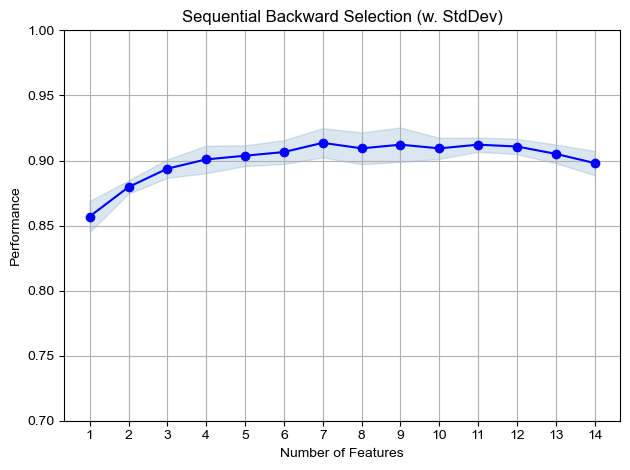

In [118]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [119]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

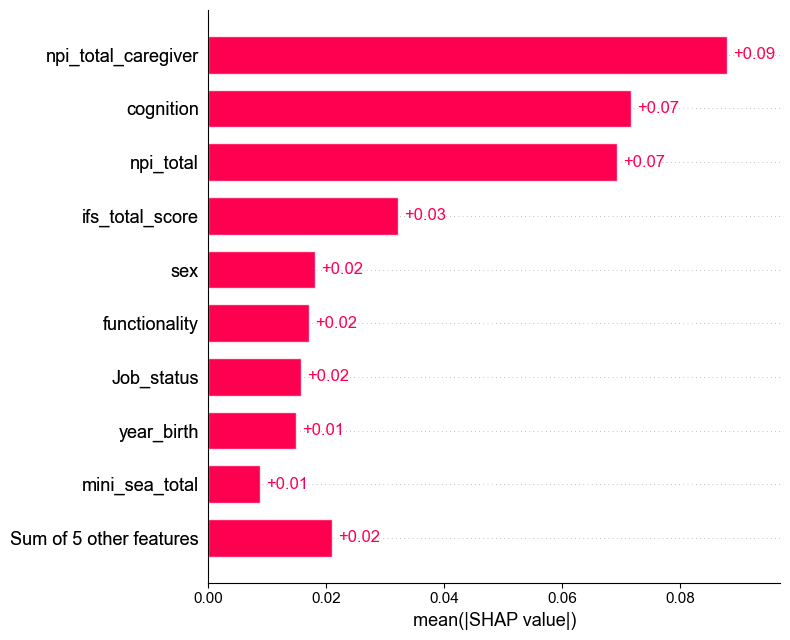

In [121]:
shap.plots.bar(shap_values[:,:,1])